# Mask R-CNN - Train on ADE20K_COCO Dataset


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

SEED = 10
np.random.seed(SEED)


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [3]:
import ade20k_coco
from ade20k_coco import Ade20kCocoConfig, Ade20kCocoDataset
config = Ade20kCocoConfig()
COCO_DIR = os.path.join(ROOT_DIR, "datasets/ade20k_coco_v4") # TODO: enter value here

config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Configurations

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Our Dataset class has the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
dataset_train = ade20k_coco.Ade20kCocoDataset()
dataset_train.load_coco(COCO_DIR, "train")

dataset_val = ade20k_coco.Ade20kCocoDataset()
dataset_val.load_coco(COCO_DIR, "val")


# Must call before using the dataset
dataset_train.prepare()
dataset_val.prepare()

print(f"Image Count (train/val): {len(dataset_train.image_ids)}/{len(dataset_val.image_ids)}")
print("Class Count: {}".format(dataset_train.num_classes))

for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=1.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Image Count (train/val): 4987/500
Class Count: 5
  0. BG                                                
  1. ceiling                                           
  2. floor, flooring                                   
  3. wall                                              
  4. windowpane, window                                


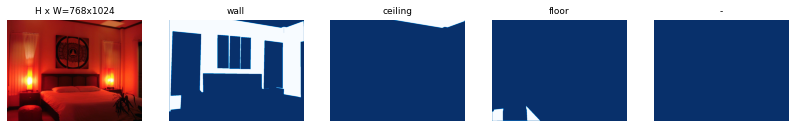

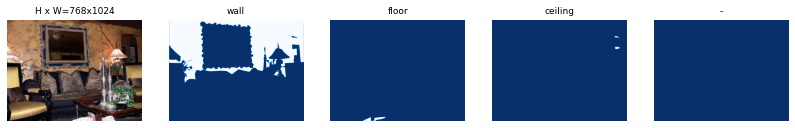

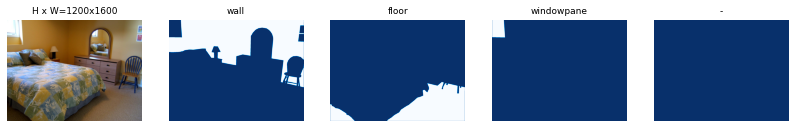

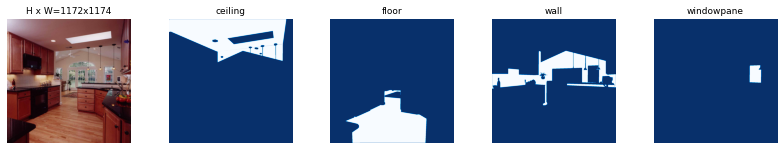

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead



In [8]:
# Which weights to start with?
# init_with options: "imagenet", "coco", or "last"
init_with = "coco"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
from ds_toolbox.ds_logging import add_log_file, set_log_level
from ds_toolbox.ds_logging import info, debug, warn, error

import imgaug.augmenters as iaa

augs = iaa.Sequential([
    iaa.Fliplr(0.5, seed=SEED),
#     iaa.Sometimes(0.5, [iaa.GaussianBlur(sigma=(0.0, 3.0))], seed=SEED),
#     iaa.Affine(scale=(0.85, 1.15), shear=(-16, 16), seed=SEED),
#     iaa.Rotate(rotate=(-45, 45), seed=SEED),
])

add_log_file("progressive.log")
set_log_level("debug")

04/13/2020 03:10:31 PM [DEBUG] Logging all output to file progressive.log


In [11]:
n_epochs = 3
layers_to_tune = "heads"

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

start = time.time()

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=n_epochs, 
            layers=layers_to_tune,
            augmentation=augs)

end = time.time()
elapsed = end - start
info("Time elapsed: {:.1f} seconds".format(elapsed))


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200413T1510/mask_rcnn_ade20k_coco_v4_{epoch:04d}.h5
In model:  rpn_model



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/3
1000/1000 [==============================] - 451s 451ms/step - loss: 1.8217 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 0.7814 - mrcnn_class_loss: 0.1704 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.4467 - val_loss: 1.6383 - val_rpn_class_loss: 0.0383 - val_rpn_bbox_loss: 0.7941 - val_mrcnn_class_loss: 0.1470 - val_mrcnn_bbox_loss: 0.2972 - val_mrcnn_mask_loss: 0.3616
Epoch 2/3
1000/1000 [==============================] - 375s 375ms/step - loss: 1.5653 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.7286 - mrcnn_class_loss: 0.1712 - mrcnn_bbox_loss: 0.2782 - mrcnn_mask_loss: 0.3514 - val_loss: 1.4360 - val_rpn_class_loss: 0.0340 - val_rpn_bbox_loss: 0.6584 - val_mrcnn_class_loss: 0.1543 - val_mrcnn_bbox_loss: 0.2636 - val_mrcnn_mask_loss: 0.3257
Epoch 3/3
1000/1000 [==============================] - 374s 374ms/step - loss: 1.4818 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6915 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.2579 - mrcnn_mask_loss: 0.3322 - val_loss: 1.5803 - val

04/13/2020 03:32:10 PM [INFO] Time elapsed: 1213.9 seconds
INFO:datascience:Time elapsed: 1213.9 seconds


In [13]:
def compute_map_val():    
    class InferenceConfig(Ade20kCocoConfig):
        # Don't use GPU for evaluation
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

    inference_config = InferenceConfig()

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference", 
                              config=inference_config,
                              model_dir=MODEL_DIR)

    # Get path to saved weights
    model_path = model.find_last()

    # Load trained weights
    debug("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    
    # Compute VOC-Style mAP @ IoU=0.5
    # Running on N=30 images. Increase for better accuracy.
    image_ids = np.random.choice(dataset_val.image_ids, 250)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)

    mAP = np.mean(APs)
    return mAP

In [14]:
mAP = compute_map_val()
info("mAP after {}: {:.4f}".format(n_epochs, mAP))

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.
04/13/2020 03:32:14 PM [DEBUG] Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200413T1510/mask_rcnn_ade20k_coco_v4_0003.h5
DEBUG:datascience:Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200413T1510/mask_rcnn_ade20k_coco_v4_0003.h5


Re-starting from epoch 3


04/13/2020 03:34:04 PM [INFO] mAP after 3: 0.5276
INFO:datascience:mAP after 3: 0.5276


In [11]:
# # Train the head branches
# # Passing layers="heads" freezes all layers except the head
# # layers. You can also pass a regular expression to select
# # which layers to train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10, 
#             epochs=16, 
#             layers='heads')

1000/1000 [==============================] - 402s 402ms/step - loss: 1.2750 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5801 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.3447 - val_loss: 1.2095 - val_rpn_class_loss: 0.0202 - val_rpn_bbox_loss: 0.5204 - val_mrcnn_class_loss: 0.1289 - val_mrcnn_bbox_loss: 0.2007 - val_mrcnn_mask_loss: 0.3393
Epoch 10/16
1000/1000 [==============================] - 388s 388ms/step - loss: 1.2547 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.5635 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.1892 - mrcnn_mask_loss: 0.3450 - val_loss: 1.3024 - val_rpn_class_loss: 0.0198 - val_rpn_bbox_loss: 0.5772 - val_mrcnn_class_loss: 0.1430 - val_mrcnn_bbox_loss: 0.2090 - val_mrcnn_mask_loss: 0.3534
Epoch 11/16
1000/1000 [==============================] - 387s 387ms/step - loss: 1.2408 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5566 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.1875 - mrcnn_mask_loss: 0.3408 - val_loss: 1.3035 - val_rpn_c

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 50, 
            epochs=16+8, 
            layers='heads')


Starting at epoch 16. LR=2e-05

Checkpoint Path: /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200407T1624/mask_rcnn_ade20k_coco_v4_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_ade20k_coco.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [13]:
class InferenceConfig(Ade20kCocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200407T1624/mask_rcnn_ade20k_coco_v4_0024.h5
Re-starting from epoch 24


## Ground Truth

In [1]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# TODO: Remove later
image_id = 117
print(f"Image id: {image_id}")

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Image id: 117


NameError: name 'modellib' is not defined

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200407T1624/mask_rcnn_ade20k_coco_v4_0005.h5 for epoch 05
Re-starting from epoch 5
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


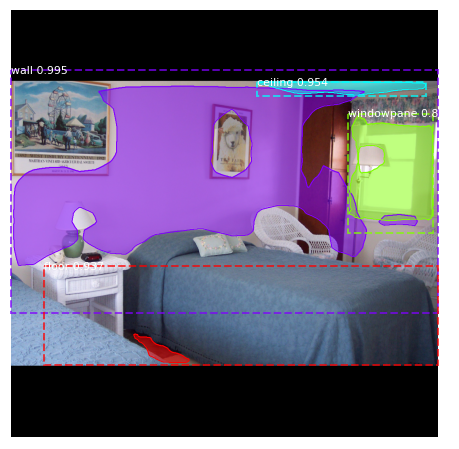

In [26]:
epoch = "05"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200407T1624/mask_rcnn_ade20k_coco_v4_0010.h5 for epoch 10
Re-starting from epoch 10
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


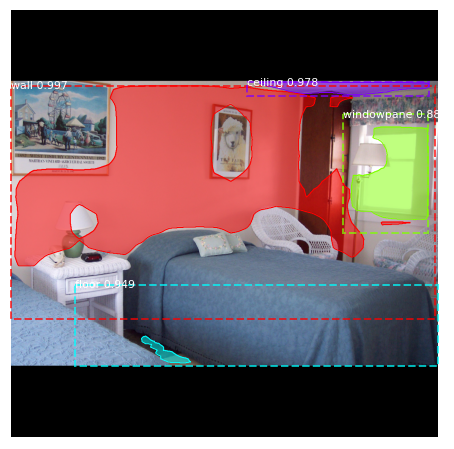

In [27]:
epoch = "10"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200407T1624/mask_rcnn_ade20k_coco_v4_0015.h5 for epoch 15
Re-starting from epoch 15
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


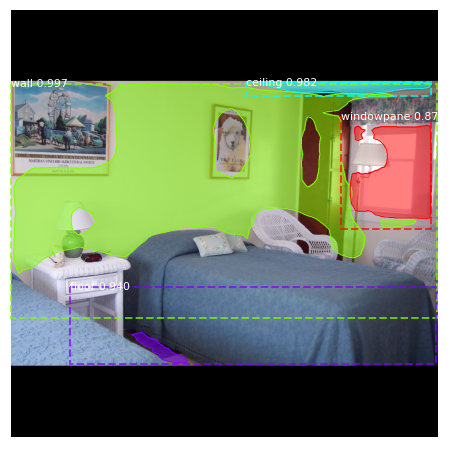

In [28]:
epoch = "15"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200407T1624/mask_rcnn_ade20k_coco_v4_0021.h5 for epoch 21
Re-starting from epoch 21
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


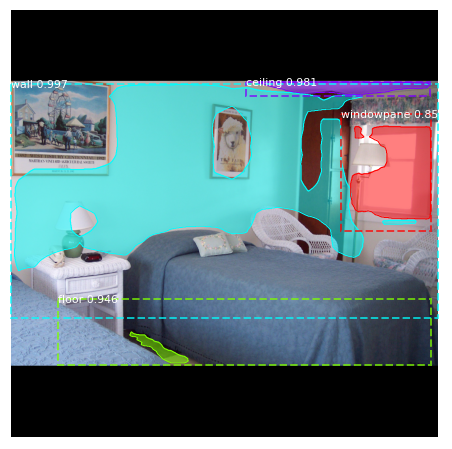

In [29]:
epoch = "21"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Eval After 5 Epochs

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200406T2042/mask_rcnn_ade20k_coco_v4_0005.h5 for epoch 05
Re-starting from epoch 5
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


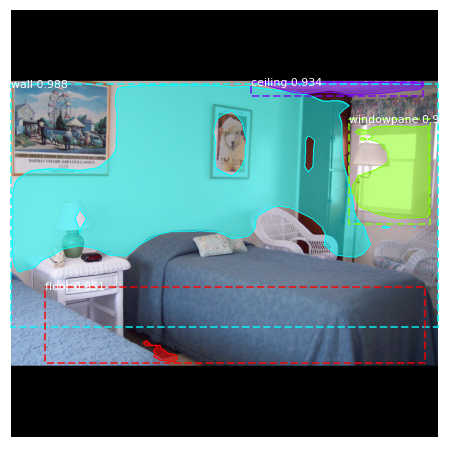

In [32]:
epoch = "05"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Eval after 10 Epochs

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200406T2042/mask_rcnn_ade20k_coco_v4_0010.h5 for epoch 10
Re-starting from epoch 10
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


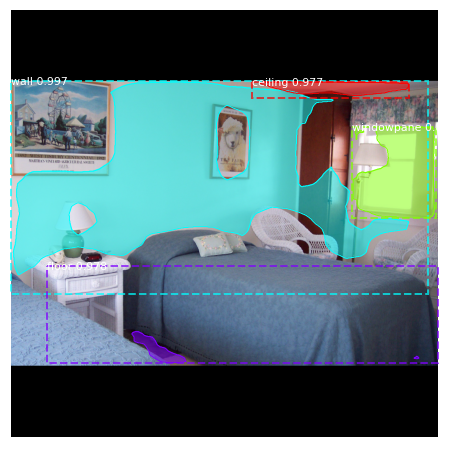

In [33]:
epoch = "10"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Eval after 15 Epochs

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200406T2042/mask_rcnn_ade20k_coco_v4_0015.h5 for epoch 15
Re-starting from epoch 15
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


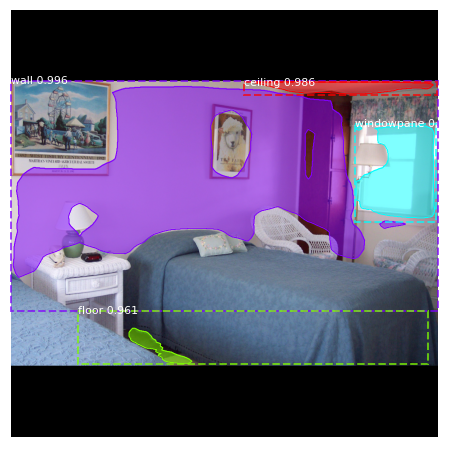

In [34]:
epoch = "15"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200406T2042/mask_rcnn_ade20k_coco_v4_0020.h5 for epoch 20
Re-starting from epoch 20
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


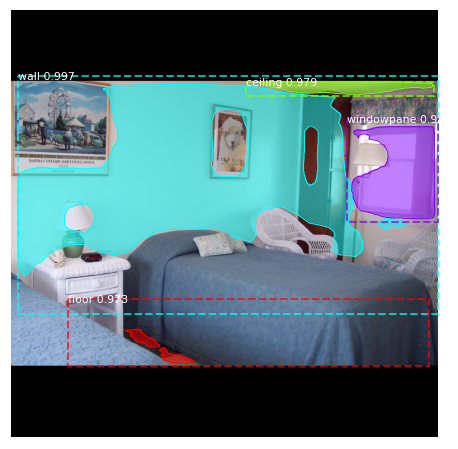

In [35]:
epoch = "20"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Loading weights from /home/mxs8x15/code/mask_rcnn_matterport/logs/ade20k_coco_v420200406T2042/mask_rcnn_ade20k_coco_v4_0025.h5 for epoch 25
Re-starting from epoch 25
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


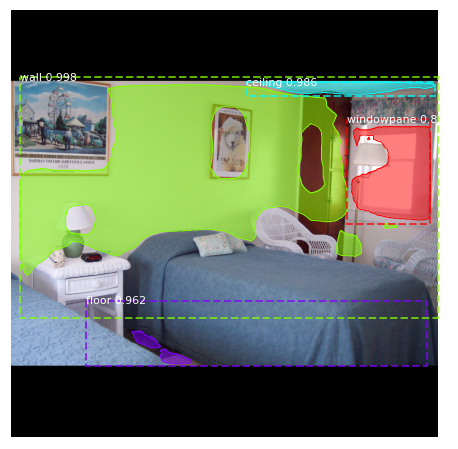

In [36]:
epoch = "25"
model_path = model.find_last()
model_path = model_path[:-7] + f"00{epoch}.h5"

# Load trained weights
print(f"Loading weights from {model_path} for epoch {epoch}")
model.load_weights(model_path, by_name=True)

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1600.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


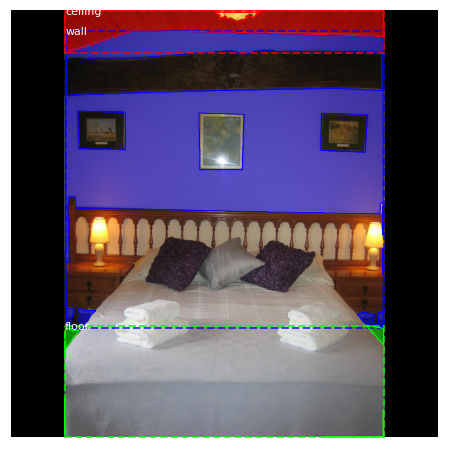

In [20]:
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


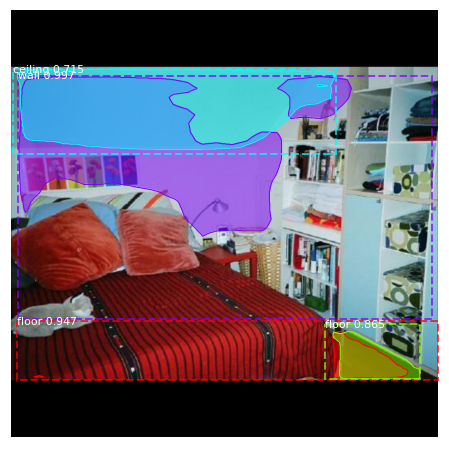

In [27]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

At epoch 25
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


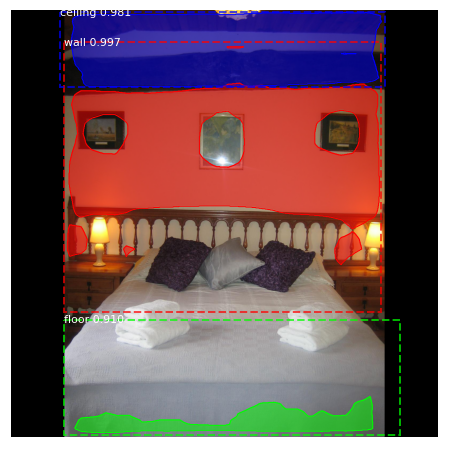

In [21]:
print("At epoch 25")
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [28]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 120)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6686210338818648


In [16]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 120)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.47956018835720093


In [37]:
%%time
print(f"After {epoch} epochs")
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 120)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

After 25 epochs
mAP:  0.6654513912068473


In [50]:
r['masks'].shape

(1024, 1024, 4)